In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_convnext_model(architecture='convnext_tiny', num_classes=4, pretrained=True):
    """Create ConvNeXt model for multi-class classification"""
    if architecture == 'convnext_tiny':
        model = timm.create_model('convnext_tiny', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_small':
        model = timm.create_model('convnext_small', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_base':
        model = timm.create_model('convnext_base', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'convnext_tiny', 'convnext_small', or 'convnext_base'")
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train ConvNeXt Tiny

Training ConvNeXt Tiny (without Imaging Type)


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:29<00:00,  1.28it/s, Loss=1.8620, Acc=0.2870]


Train Loss: 1.8620 Acc: 0.2870 Macro-F1: 0.2404


Val : 100%|██████████| 10/10 [00:03<00:00,  3.00it/s, Loss=1.4881, Acc=0.3684]


Val Loss: 1.4881 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:26<00:00,  1.43it/s, Loss=1.4303, Acc=0.2451]


Train Loss: 1.4303 Acc: 0.2451 Macro-F1: 0.2244


Val : 100%|██████████| 10/10 [00:01<00:00,  8.06it/s, Loss=1.3513, Acc=0.3684]


Val Loss: 1.3513 Acc: 0.3684 Macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:26<00:00,  1.43it/s, Loss=1.4363, Acc=0.2401]


Train Loss: 1.4363 Acc: 0.2401 Macro-F1: 0.2055


Val : 100%|██████████| 10/10 [00:01<00:00,  7.89it/s, Loss=1.3708, Acc=0.2829]


Val Loss: 1.3708 Acc: 0.2829 Macro-F1: 0.1103

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:26<00:00,  1.43it/s, Loss=1.4227, Acc=0.2582]


Train Loss: 1.4227 Acc: 0.2582 Macro-F1: 0.2254


Val : 100%|██████████| 10/10 [00:01<00:00,  8.04it/s, Loss=1.4465, Acc=0.0724]


Val Loss: 1.4465 Acc: 0.0724 Macro-F1: 0.0337

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:26<00:00,  1.43it/s, Loss=1.4138, Acc=0.2253]


Train Loss: 1.4138 Acc: 0.2253 Macro-F1: 0.2120


Val : 100%|██████████| 10/10 [00:01<00:00,  7.94it/s, Loss=1.4039, Acc=0.2829]


Val Loss: 1.4039 Acc: 0.2829 Macro-F1: 0.1103

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:26<00:00,  1.43it/s, Loss=1.4060, Acc=0.2632]


Train Loss: 1.4060 Acc: 0.2632 Macro-F1: 0.2248


Val : 100%|██████████| 10/10 [00:01<00:00,  8.03it/s, Loss=1.3874, Acc=0.0724]


Val Loss: 1.3874 Acc: 0.0724 Macro-F1: 0.0419
Early stopping triggered after 6 epochs
Training complete in 2m 52s
Best validation macro-F1: 0.1346


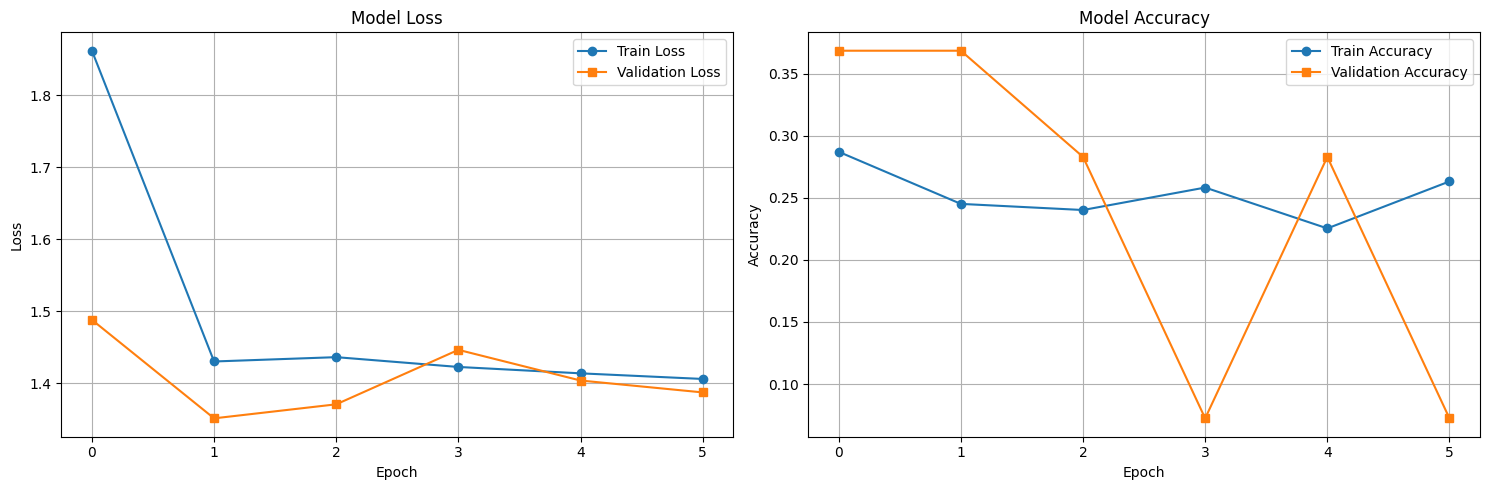

Evaluating on test set...


100%|██████████| 6/6 [00:03<00:00,  1.96it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 28.04%
Test Loss: 1.4257

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.28      1.00      0.44        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.28       189
   macro avg       0.07      0.25      0.11       189
weighted avg       0.08      0.28      0.12       189


Confusion Matrix:
[[ 0 74  0  0]
 [ 0 53  0  0]
 [ 0 37  0  0]
 [ 0 25  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.5161
Micro-average AUC: 0.5028
HGC AUC: 0.7469
LGC AUC: 0.1410
NST AUC: 0.6055
NTL AUC: 0.5710


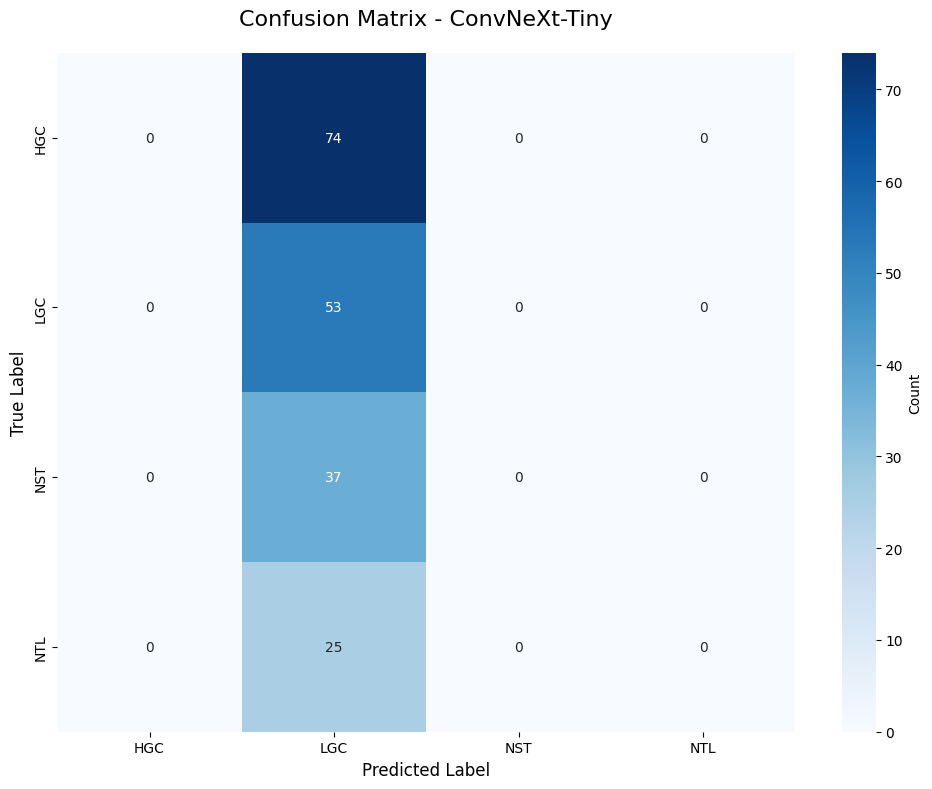

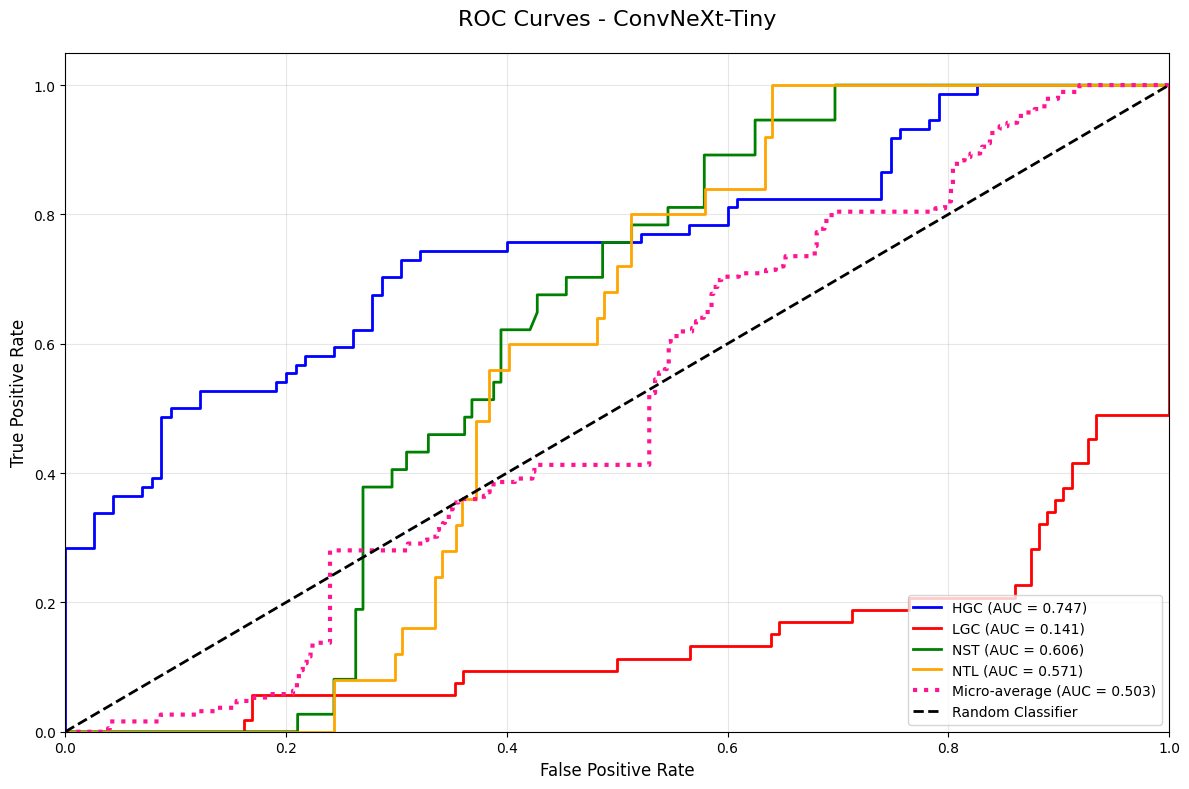


ConvNeXt Tiny training and evaluation complete!


In [16]:
print("=" * 80)
print("Training ConvNeXt Tiny (without Imaging Type)")
print("=" * 80)

# Create model
convnext_tiny = create_convnext_model(architecture='convnext_tiny', num_classes=4, pretrained=True)

# Create trainer
trainer_convnext_tiny = ModelTrainer(convnext_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_convnext_tiny = trainer_convnext_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ConvNeXt-Tiny")

# Plot training history
trainer_convnext_tiny.plot_training_history(save_path='convnext_tiny_training_history.png')

# Evaluate model
results_convnext_tiny = trainer_convnext_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_convnext_tiny['confusion_matrix'], class_names, 'ConvNeXt-Tiny',
                      save_path='convnext_tiny_confusion_matrix.png')

# Plot ROC curves
roc_auc_convnext_tiny = plot_roc_curves(results_convnext_tiny['labels'], results_convnext_tiny['probabilities'], class_names, 'ConvNeXt-Tiny',
                                     save_path='convnext_tiny_roc_curves.png')

# Store results
results_convnext_tiny['model_name'] = 'ConvNeXt-Tiny'
results_convnext_tiny['roc_auc'] = roc_auc_convnext_tiny
all_results.append(results_convnext_tiny)

print("\nConvNeXt Tiny training and evaluation complete!")

## Train ConvNeXt Base

Training ConvNeXt Base (without Imaging Type)


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.52s/it, Loss=1.5693, Acc=0.2566]


Train Loss: 1.5693 Acc: 0.2566 Macro-F1: 0.2321


Val : 100%|██████████| 10/10 [00:04<00:00,  2.35it/s, Loss=1.3601, Acc=0.3684]


Val Loss: 1.3601 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.48s/it, Loss=1.4546, Acc=0.2533]


Train Loss: 1.4546 Acc: 0.2533 Macro-F1: 0.2307


Val : 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, Loss=1.3979, Acc=0.3684]


Val Loss: 1.3979 Acc: 0.3684 Macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.48s/it, Loss=1.4010, Acc=0.2771]


Train Loss: 1.4010 Acc: 0.2771 Macro-F1: 0.2451


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=1.3703, Acc=0.2763]


Val Loss: 1.3703 Acc: 0.2763 Macro-F1: 0.1082

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.48s/it, Loss=1.4063, Acc=0.2714]


Train Loss: 1.4063 Acc: 0.2714 Macro-F1: 0.2348


Val : 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, Loss=1.4105, Acc=0.0724]


Val Loss: 1.4105 Acc: 0.0724 Macro-F1: 0.0337

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.48s/it, Loss=1.3998, Acc=0.2854]


Train Loss: 1.3998 Acc: 0.2854 Macro-F1: 0.2446


Val : 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, Loss=1.3468, Acc=0.3684]


Val Loss: 1.3468 Acc: 0.3684 Macro-F1: 0.1346

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.48s/it, Loss=1.4011, Acc=0.3026]


Train Loss: 1.4011 Acc: 0.3026 Macro-F1: 0.2293


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=1.3725, Acc=0.3684]


Val Loss: 1.3725 Acc: 0.3684 Macro-F1: 0.1346
Early stopping triggered after 6 epochs
Training complete in 5m 57s
Best validation macro-F1: 0.1346


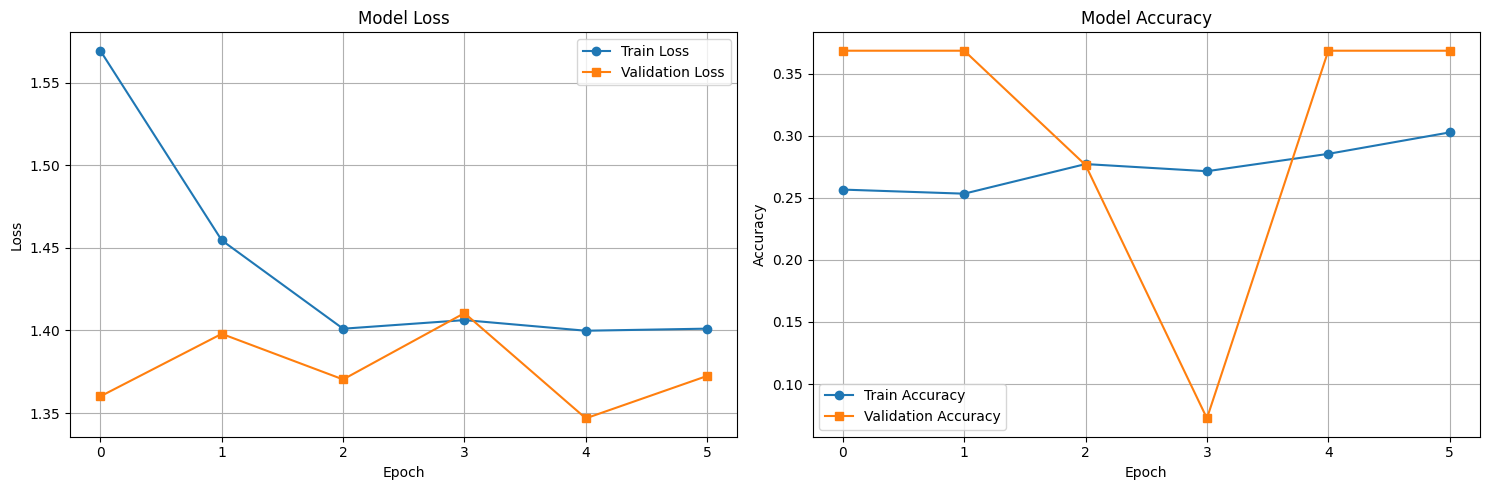

Evaluating on test set...


100%|██████████| 6/6 [00:03<00:00,  1.80it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 28.04%
Test Loss: 1.4284

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.28      1.00      0.44        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.28       189
   macro avg       0.07      0.25      0.11       189
weighted avg       0.08      0.28      0.12       189


Confusion Matrix:
[[ 0 74  0  0]
 [ 0 53  0  0]
 [ 0 37  0  0]
 [ 0 25  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.6915
Micro-average AUC: 0.5936
HGC AUC: 0.6405
LGC AUC: 0.8867
NST AUC: 0.9095
NTL AUC: 0.3293


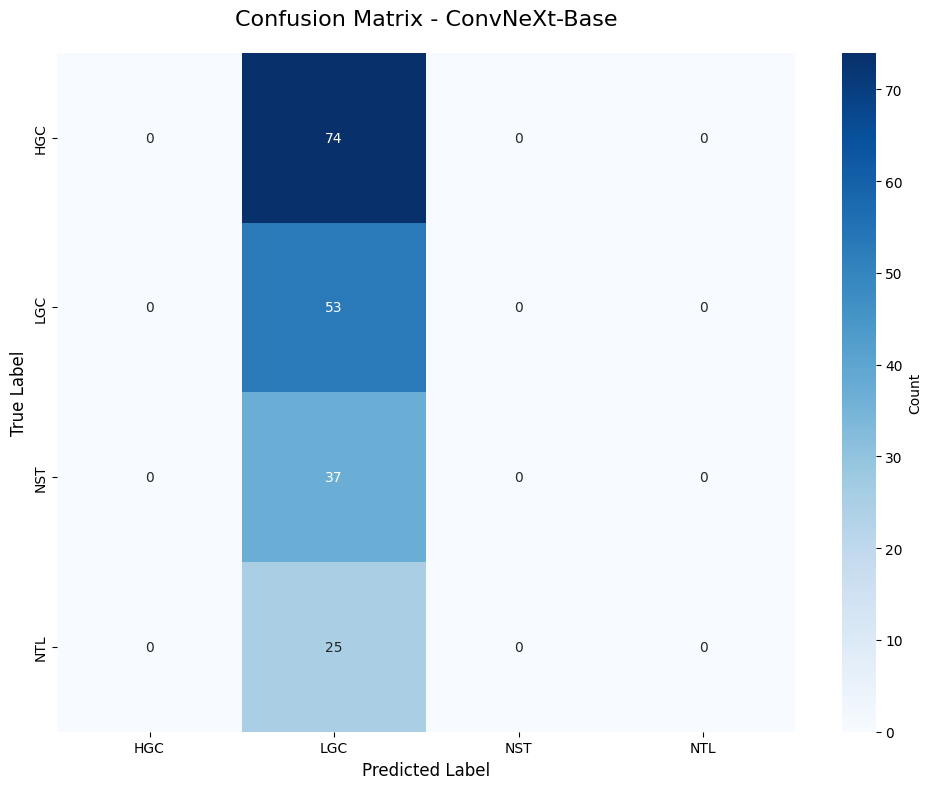

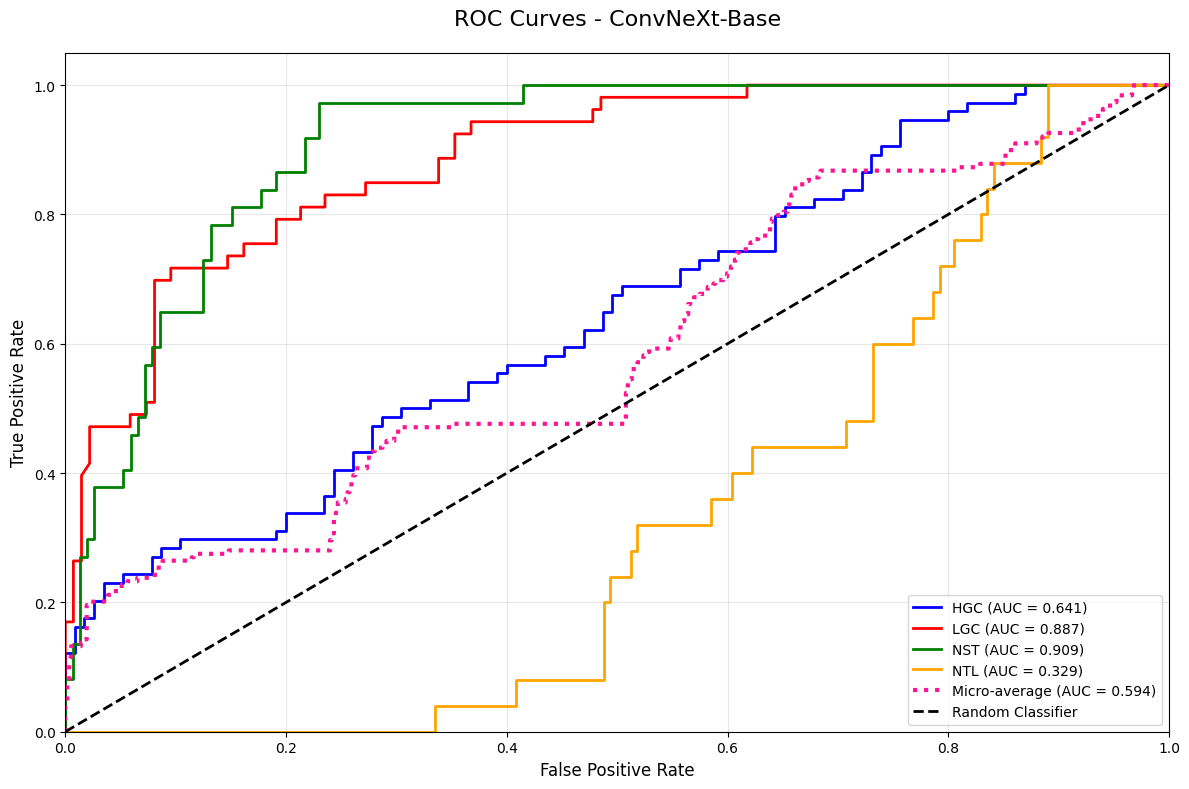


ConvNeXt Base training and evaluation complete!


In [17]:
print("=" * 80)
print("Training ConvNeXt Base (without Imaging Type)")
print("=" * 80)

# Create model
convnext_base = create_convnext_model(architecture='convnext_base', num_classes=4, pretrained=True)

# Create trainer
trainer_convnext_base = ModelTrainer(convnext_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_convnext_base = trainer_convnext_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ConvNeXt-Base")

# Plot training history
trainer_convnext_base.plot_training_history(save_path='convnext_base_training_history.png')

# Evaluate model
results_convnext_base = trainer_convnext_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_convnext_base['confusion_matrix'], class_names, 'ConvNeXt-Base',
                      save_path='convnext_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_convnext_base = plot_roc_curves(results_convnext_base['labels'], results_convnext_base['probabilities'], class_names, 'ConvNeXt-Base',
                                     save_path='convnext_base_roc_curves.png')

# Store results
results_convnext_base['model_name'] = 'ConvNeXt-Base'
results_convnext_base['roc_auc'] = roc_auc_convnext_base
all_results.append(results_convnext_base)

print("\nConvNeXt Base training and evaluation complete!")

## Train ConvNeXt Small

Training ConvNeXt Small (without Imaging Type)


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.8606, Acc=0.2459]


Train Loss: 1.8606 Acc: 0.2459 Macro-F1: 0.2315


Val : 100%|██████████| 10/10 [00:01<00:00,  5.34it/s, Loss=1.4092, Acc=0.2763]


Val Loss: 1.4092 Acc: 0.2763 Macro-F1: 0.1082
✓ New best model saved with validation macro-F1: 0.1082

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.4484, Acc=0.2599]


Train Loss: 1.4484 Acc: 0.2599 Macro-F1: 0.2315


Val : 100%|██████████| 10/10 [00:01<00:00,  5.39it/s, Loss=1.5052, Acc=0.0724]


Val Loss: 1.5052 Acc: 0.0724 Macro-F1: 0.0337

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.4169, Acc=0.2303]


Train Loss: 1.4169 Acc: 0.2303 Macro-F1: 0.2136


Val : 100%|██████████| 10/10 [00:01<00:00,  5.41it/s, Loss=1.4033, Acc=0.2763]


Val Loss: 1.4033 Acc: 0.2763 Macro-F1: 0.1082

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.4211, Acc=0.2788]


Train Loss: 1.4211 Acc: 0.2788 Macro-F1: 0.2460


Val : 100%|██████████| 10/10 [00:01<00:00,  5.38it/s, Loss=1.3815, Acc=0.2829]


Val Loss: 1.3815 Acc: 0.2829 Macro-F1: 0.1103
✓ New best model saved with validation macro-F1: 0.1103

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.4296, Acc=0.2171]


Train Loss: 1.4296 Acc: 0.2171 Macro-F1: 0.2061


Val : 100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Loss=1.4551, Acc=0.0724]


Val Loss: 1.4551 Acc: 0.0724 Macro-F1: 0.0337

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.4168, Acc=0.2475]


Train Loss: 1.4168 Acc: 0.2475 Macro-F1: 0.2211


Val : 100%|██████████| 10/10 [00:01<00:00,  5.34it/s, Loss=1.4527, Acc=0.0724]


Val Loss: 1.4527 Acc: 0.0724 Macro-F1: 0.0337

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.4343, Acc=0.2344]


Train Loss: 1.4343 Acc: 0.2344 Macro-F1: 0.1933


Val : 100%|██████████| 10/10 [00:01<00:00,  5.33it/s, Loss=1.3443, Acc=0.2829]


Val Loss: 1.3443 Acc: 0.2829 Macro-F1: 0.1103

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.3979, Acc=0.2541]


Train Loss: 1.3979 Acc: 0.2541 Macro-F1: 0.1461


Val : 100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Loss=1.3694, Acc=0.2763]


Val Loss: 1.3694 Acc: 0.2763 Macro-F1: 0.1082

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.3870, Acc=0.3306]


Train Loss: 1.3870 Acc: 0.3306 Macro-F1: 0.1953


Val : 100%|██████████| 10/10 [00:01<00:00,  5.33it/s, Loss=1.3773, Acc=0.3684]


Val Loss: 1.3773 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.3869, Acc=0.2961]


Train Loss: 1.3869 Acc: 0.2961 Macro-F1: 0.2214


Val : 100%|██████████| 10/10 [00:01<00:00,  5.30it/s, Loss=1.3741, Acc=0.2829]


Val Loss: 1.3741 Acc: 0.2829 Macro-F1: 0.1103

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.3879, Acc=0.3232]


Train Loss: 1.3879 Acc: 0.3232 Macro-F1: 0.1950


Val : 100%|██████████| 10/10 [00:01<00:00,  5.37it/s, Loss=1.3737, Acc=0.3684]


Val Loss: 1.3737 Acc: 0.3684 Macro-F1: 0.1346

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.3877, Acc=0.3931]


Train Loss: 1.3877 Acc: 0.3931 Macro-F1: 0.1411


Val : 100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Loss=1.3741, Acc=0.3684]


Val Loss: 1.3741 Acc: 0.3684 Macro-F1: 0.1346

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.3880, Acc=0.2878]


Train Loss: 1.3880 Acc: 0.2878 Macro-F1: 0.1668


Val : 100%|██████████| 10/10 [00:01<00:00,  5.33it/s, Loss=1.3682, Acc=0.3684]


Val Loss: 1.3682 Acc: 0.3684 Macro-F1: 0.1346

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.09s/it, Loss=1.3868, Acc=0.2845]


Train Loss: 1.3868 Acc: 0.2845 Macro-F1: 0.1549


Val : 100%|██████████| 10/10 [00:01<00:00,  5.38it/s, Loss=1.3830, Acc=0.2829]


Val Loss: 1.3830 Acc: 0.2829 Macro-F1: 0.1103
Early stopping triggered after 14 epochs
Training complete in 10m 9s
Best validation macro-F1: 0.1346


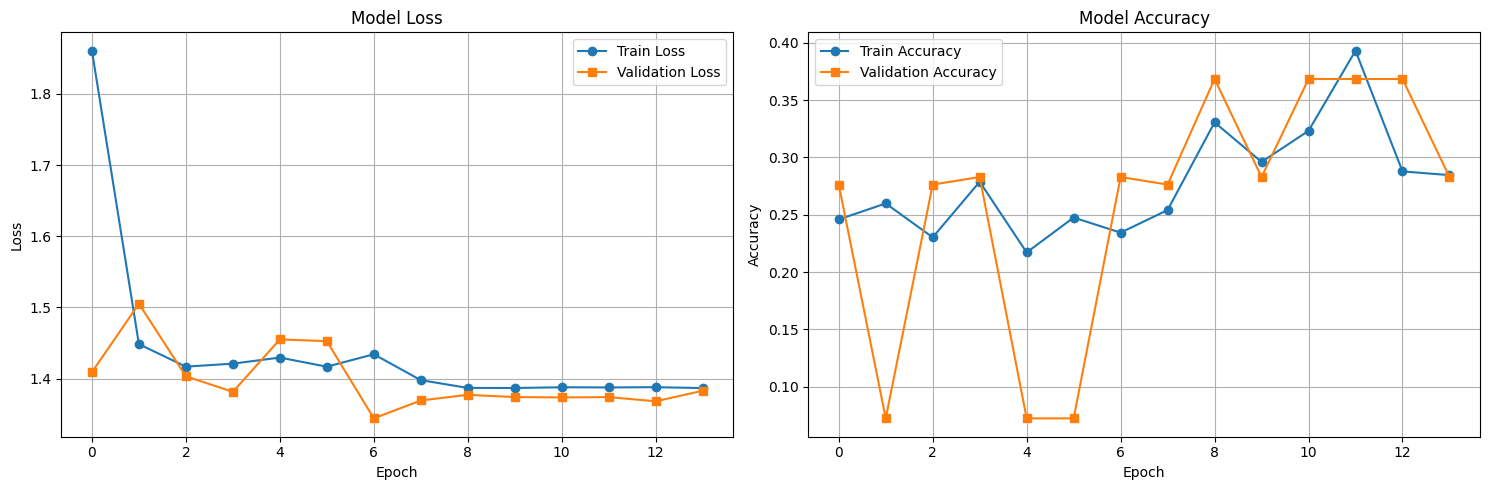

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 28.04%
Test Loss: 1.3780

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.28      1.00      0.44        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.28       189
   macro avg       0.07      0.25      0.11       189
weighted avg       0.08      0.28      0.12       189


Confusion Matrix:
[[ 0 74  0  0]
 [ 0 53  0  0]
 [ 0 37  0  0]
 [ 0 25  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.4528
Micro-average AUC: 0.5836
HGC AUC: 0.2566
LGC AUC: 0.2006
NST AUC: 0.7019
NTL AUC: 0.6520


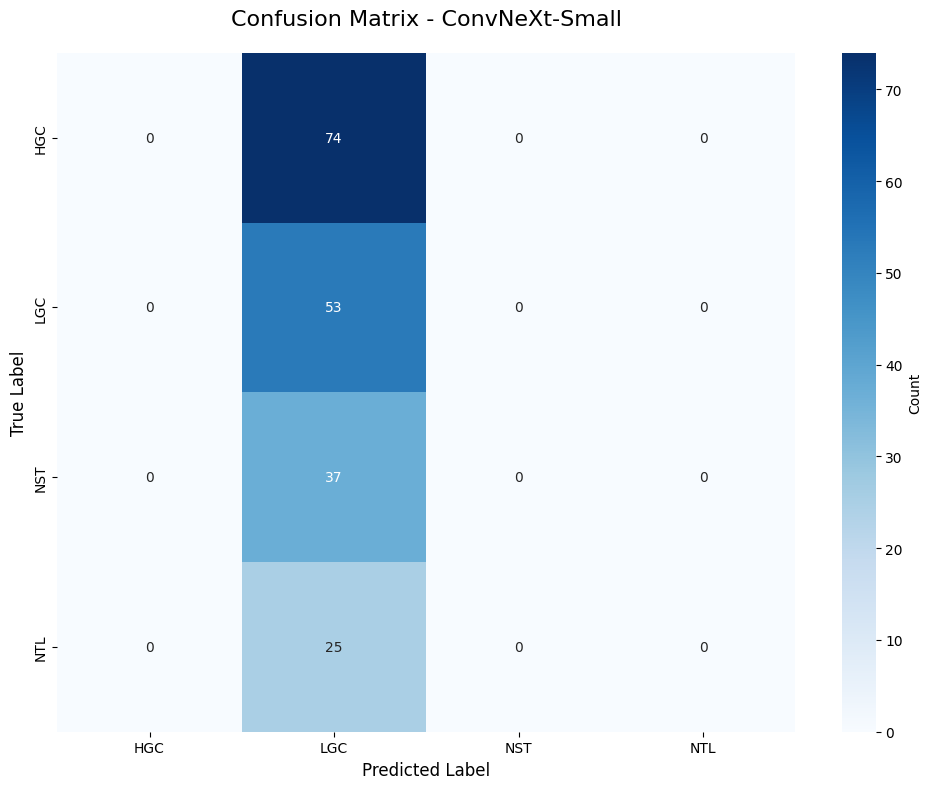

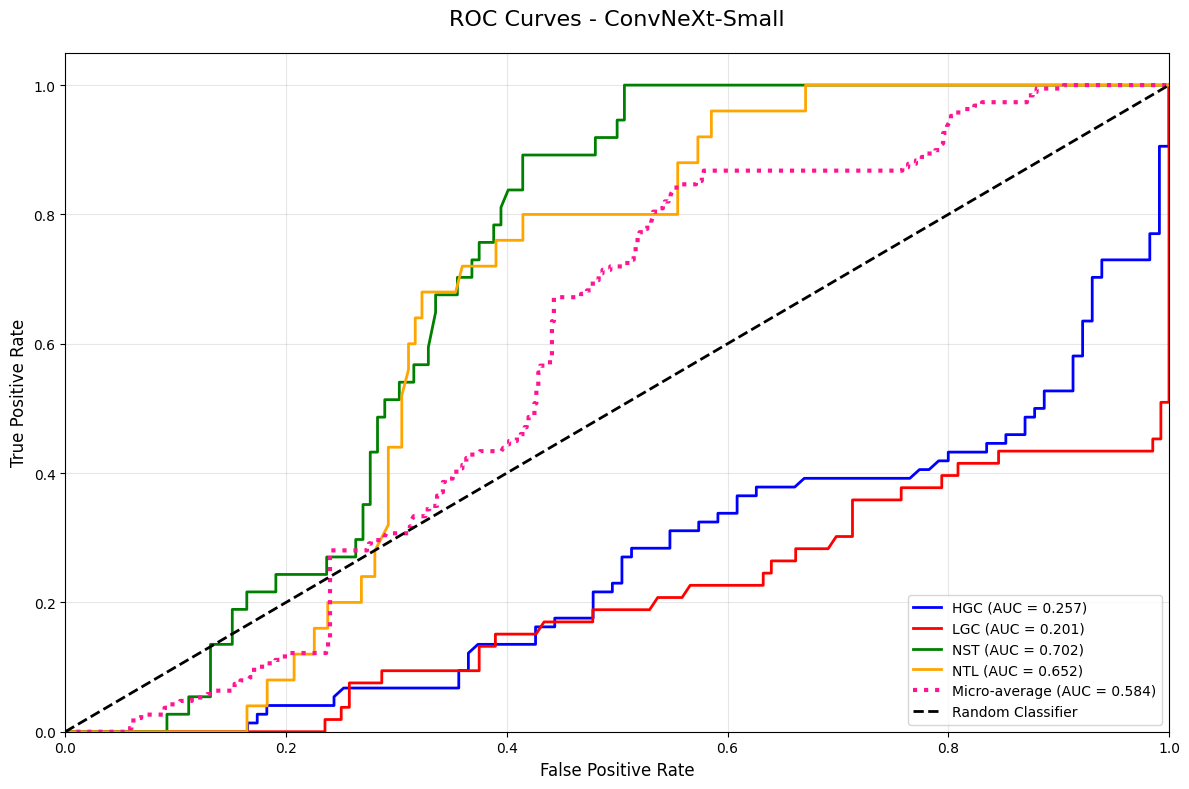


ConvNeXt Small training and evaluation complete!


In [18]:
print("=" * 80)
print("Training ConvNeXt Small (without Imaging Type)")
print("=" * 80)

# Create model
convnext_small = create_convnext_model(architecture='convnext_small', num_classes=4, pretrained=True)

# Create trainer
trainer_convnext_small = ModelTrainer(convnext_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_convnext_small = trainer_convnext_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ConvNeXt-Small")

# Plot training history
trainer_convnext_small.plot_training_history(save_path='convnext_small_training_history.png')

# Evaluate model
results_convnext_small = trainer_convnext_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_convnext_small['confusion_matrix'], class_names, 'ConvNeXt-Small',
                      save_path='convnext_small_confusion_matrix.png')

# Plot ROC curves
roc_auc_convnext_small = plot_roc_curves(results_convnext_small['labels'], results_convnext_small['probabilities'], class_names, 'ConvNeXt-Small',
                                     save_path='convnext_small_roc_curves.png')

# Store results
results_convnext_small['model_name'] = 'ConvNeXt-Small'
results_convnext_small['roc_auc'] = roc_auc_convnext_small
all_results.append(results_convnext_small)

print("\nConvNeXt Small training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'ConvNeXt_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: ConvNeXt_metrics.csv

Metrics Summary:
            Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall  HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall  NST_F1  NST_Support  NTL_Precision  NTL_Recall  NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   ConvNeXt-Tiny         28.042328      1.425708             0.070106              0.25      0.109504                0.078637             0.280423          0.12283            0.0         0.0     0.0         74.0       0.280423         1.0  0.438017         53.0            0.0         0.0     0.0         37.0            0.0         0.0     0.0         25.0   0.516086   0.502827  0.746886  0.140954  0.605530  0.570976      0.746886      0.140